In [1]:
# Import dependencies 
import joblib  
import numpy as np  
import pandas as pd
import hvplot.pandas
import seaborn as sns 
import matplotlib.pyplot as plt 
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sqlalchemy import create_engine, MetaData
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
import streamlit as st 

# Load and Review DataFrame 

In [2]:
# Database Setup
engine = create_engine("sqlite:///Coding/Data_Engineering.db")

# Reflect the tables
metadata = MetaData()
metadata.reflect(bind=engine)
coffee_data = metadata.tables['coffee_data']

# Fetch data from the database
conn = engine.connect()
result = conn.execute(coffee_data.select()).fetchall()
conn.close()

# Convert each row to a dictionary
data = [dict(row._asdict()) for row in result]

# Create a DataFrame
coffee_data_df = pd.DataFrame(data)

In [3]:
# Check database has been loaded 
coffee_data_df.head()

,slug,name,roaster,roast,country_of_origin,desc_1,desc_2,latitude,longitude,rating,...,region_hawaii,region_asia_pacific,region_south_america,type_espresso,type_organic,type_fair_trade,type_decaffeinated,type_pod_capsule,type_blend,type_estate
0,/review/ethiopia-deri-kochoha-2,Ethiopia Deri Kochoha,Flight Coffee Co.,Medium-Light,Ethiopia,"Bright, crisp, sweetly tart. Citrus medley, ca...",From the Deri Kochoha mill in the Hagere Marya...,6.767800,35.634371,93,...,0,0,0,0,0,0,0,0,0,0
1,/review/kenya-ruthaka-peaberry,Kenya Ruthaka Peaberry,Temple Coffee and Tea,Medium,Kenya,"Deeply sweet, richly savory. Dark chocolate, p...",Despite challenges ranging from contested gove...,1.441968,38.431398,95,...,0,0,0,0,0,0,0,0,0,0
2,/review/ethiopia-gora-kone-sidamo,Ethiopia Gora Kone Sidamo,Temple Coffee and Tea,Medium-Light,Ethiopia,"Fruitforward, richly chocolaty. Raspberry coul...",Southern Ethiopia coffees like this one are la...,6.767800,35.634371,93,...,0,0,0,0,0,0,0,0,0,0
3,/review/honduras-las-flores-parainema,Honduras Las Flores Parainema,Café Grumpy,Medium-Light,Honduras,"Spicetoned, complex, richly bittersweet. Black...",Produced by César Fernandez of El Cielito farm...,15.257243,-86.075514,94,...,0,0,0,0,0,0,0,0,0,0
4,/review/kivu-dr-congo,Kivu DR Congo,JBC Coffee Roasters,Medium-Light,"Congo, The Democratic Republic of the","Hightoned, balanced, crisply sweet. Apricot, t...",Produced entirely from trees of Bourbonrelated...,-2.981434,23.822264,94,...,0,0,0,0,1,1,0,0,0,0


## Assess and Implement model

In [4]:
# Create features and target
coffee_data_df_features = coffee_data_df[['aroma','body','flavor','acid','aftertaste']]

In [5]:
# Select features array 
features = ['aroma', 'flavor', 'acid', 'body', 'aftertaste'] 

In [6]:
# Calculate mean, median, standard deviation, and range for each feature
summary_stats = coffee_data_df_features[features].describe().transpose()

# Display the summary statistics
print(summary_stats)

             count      mean       std  min  25%  50%  75%   max
aroma       3001.0  8.531823  0.643224  5.0  8.0  9.0  9.0  10.0
flavor      3001.0  8.696101  0.640012  3.0  8.0  9.0  9.0  10.0
acid        3001.0  8.024992  0.660082  4.0  8.0  8.0  8.0  10.0
body        3001.0  8.200267  0.613362  6.0  8.0  8.0  9.0  10.0
aftertaste  3001.0  8.026325  0.658007  4.0  8.0  8.0  8.0  10.0


- <b> Aroma: </b> Interpretation: The average aroma rating is around 8.47, with a moderate level of variability (standard deviation of 0.70). Ratings range from 4.0 to 10.0, with the majority falling between 8.0 and 9.0.
- <b> Flavor: </b>  Interpretation: The average flavor rating is around 8.62, with a moderate level of variability (standard deviation of 0.73). Ratings range from 1.0 to 10.0, with the majority falling between 8.0 and 9.0.
- <b> Acid: </b> Interpretation: The average acidity rating is around 7.97, with a moderate level of variability (standard deviation of 0.71). Ratings range from 3.0 to 10.0, with the majority falling between 8.0 and 8.0
- <b> Body: </b> Interpretation: The average body rating is around 8.16, with a relatively low level of variability (standard deviation of 0.63). Ratings range from 6.0 to 10.0, with the majority falling between 8.0 and 9.0.
- <b> Interpretation: </b> The average aftertaste rating is around 7.97, with a moderate level of variability (standard deviation of 0.71). Ratings range from 3.0 to 10.0, with the majority falling between 8.0 and 8.0

This is due to the fact that the ratings are over 60 which means that these are coffees are probably on the higher end of coffee ratings. 

# Standardise Data 

In [7]:
# Create the StandardScaler instance
scaler = StandardScaler()

In [8]:
# Fit the Standard Scaler with the training data
coffee_data_scaled =scaler.fit_transform(coffee_data_df_features[features])

# PCA Implementation 

In [9]:
# Create a PCA instance
pca = PCA()

# Fit PCA to your scaled data
pca.fit(coffee_data_scaled)

# Calculate the explained variance for each component
explained_variance = pca.explained_variance_ratio_
print("Explained Variance Ratio for Each Component:")
print(explained_variance)


Explained Variance Ratio for Each Component:
[0.56045285 0.23316718 0.12801336 0.07760103 0.00076558]


In [10]:
# Calculate the cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance)

# Print the cumulative explained variance
print("Cumulative Explained Variance:")
print(cumulative_explained_variance)

Cumulative Explained Variance:
[0.56045285 0.79362003 0.92163339 0.99923442 1.        ]


In [11]:
# Reduce dimensionality to 3 components for interpretability and simplicity
pca = PCA(n_components=3)

coffee_data_pca = pca.fit_transform(coffee_data_scaled)

# Calculate the explained variance for each component
explained_variance_3 = pca.explained_variance_ratio_
print("Explained Variance Ratio for Each Component:")
print(explained_variance_3) 

Explained Variance Ratio for Each Component:
[0.56045285 0.23316718 0.12801336]


In [12]:
coffee_data_pca

array([[-0.90209124, -1.15247999, -0.50885535],
       [-1.63426012, -1.62672903, -0.19131985],
       [-0.90209124, -1.15247999, -0.50885535],
       ...,
       [ 5.13487348,  1.86064463, -0.53075168],
       [ 4.4027046 ,  1.38639559, -0.21321618],
       [ 3.67053572,  0.91214655,  0.10431931]])

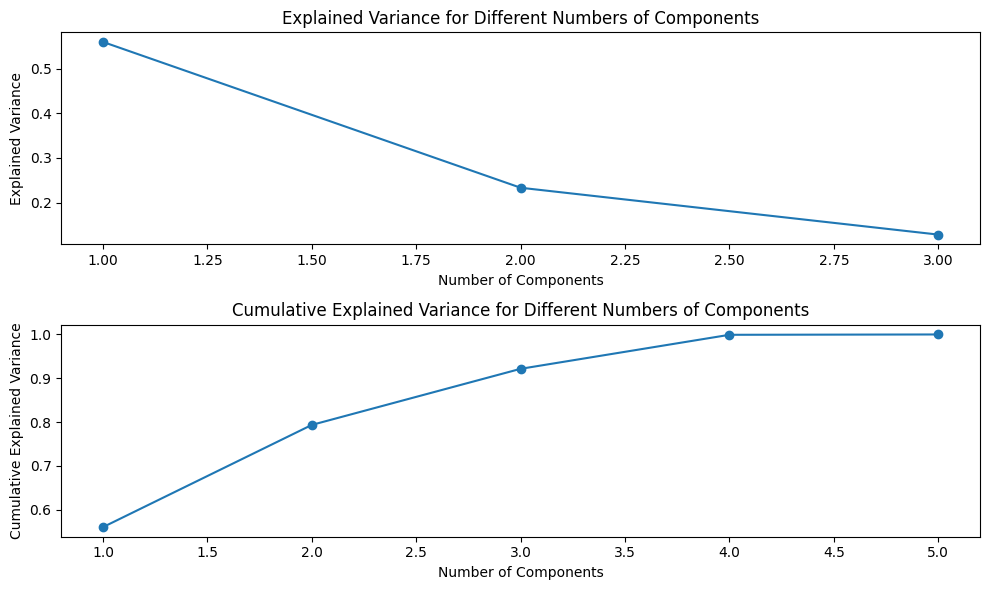

In [13]:
# Plot the explained variance and the cumulative explained variance
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(range(1, len(explained_variance_3) + 1), explained_variance_3, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.title('Explained Variance for Different Numbers of Components')

plt.subplot(2, 1, 2)
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance for Different Numbers of Components')

plt.tight_layout()
plt.show()

### Summary: 
- <b> Component 1 (56.04%): </b> This component explains a significant portion of the dataset's variance, suggesting that it captures the most critical patterns or features in the original data. It can be considered the most dominant factor in the reduced-dimensional representation.

- <b> Component 2 (23.31%): </b> While not as influential as the first component, the second component still contributes substantially to the overall variance. It captures additional patterns that are orthogonal to those captured by the first component.

- <b> Component 3 (12.80%): </b> This component contributes less to the overall variance but still captures unique patterns in the data that were not accounted for by the first two components.

### Cumulative Explained Variance Ratio: 92.16%

In [14]:
# Create the PCA DataFrame
coffee_pca_df = pd.DataFrame(
    coffee_data_pca,
    columns=["PCA1", "PCA2", "PCA3"]
)

# Review the PCA DataFrame
coffee_pca_df.head()

,PCA1,PCA2,PCA3
0,-0.902091,-1.152480,-0.508855
1,-1.634260,-1.626729,-0.191320
2,-0.902091,-1.152480,-0.508855
3,-0.902091,-1.152480,-0.508855
4,-0.902091,-1.152480,-0.508855


In [15]:
# # Create a list to store inertia values and the values of k
# inertia = []
# k_values = list(range(1, 11))

# # Append the value of the computed inertia from the KMeans model
# for k in k_values:
#     k_model = PCA(n_clusters=k, n_init=10, random_state=1)
#     k_model.fit(coffee_data_scaled)
#     inertia.append(k_model.inertia_)

# # Plot the Elbow Curve
# plt.plot(k_values, inertia, marker='o')
# plt.xlabel('Number of Clusters (k)')
# plt.ylabel('Inertia')
# plt.title('Elbow Curve')
# plt.show()


In [16]:
# # Create a list to store inertia values and the values of k
# inertia = []
# k = list(range(1, 11))

# # Append the value of the computed inertia from the `inertia_` attribute of the KMeans model instance
# for i in k:
#     k_model = KMeans(n_clusters=i, n_init=10, random_state=1)  # Explicitly set n_init
#     k_model.fit(coffee_pca_df)
#     inertia.append(k_model.inertia_)

# # Define a DataFrame to hold the values for k and the corresponding inertia
# elbow_data = {"k": k, "inertia": inertia}
# df_elbow = pd.DataFrame(elbow_data)

In [17]:
# # Review the DataFrame
# print("PCA Elbow Curve DataFrame:")
# print(df_elbow.head())

In [18]:
# # Plot the Elbow Curve
# df_elbow.hvplot.line(
#     x="k", 
#     y="inertia", 
#     title=" PCA Elbow Curve", 
#     xticks=k
# )

In [19]:
# Define the model with 3 clusters
model = KMeans(n_clusters=3, random_state=0, n_init =10)

# Fit the model
model.fit(coffee_pca_df)

# Make predictions
k_3 = model.predict(coffee_pca_df)

# Create a copy of the PCA DataFrame
coffee_info_pca_predictions_df = coffee_pca_df.copy()

# Add a class column with the labels
coffee_info_pca_predictions_df["coffee_segments"] = k_3

c:\Users\jesss\anaconda3\envs\PythonData\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


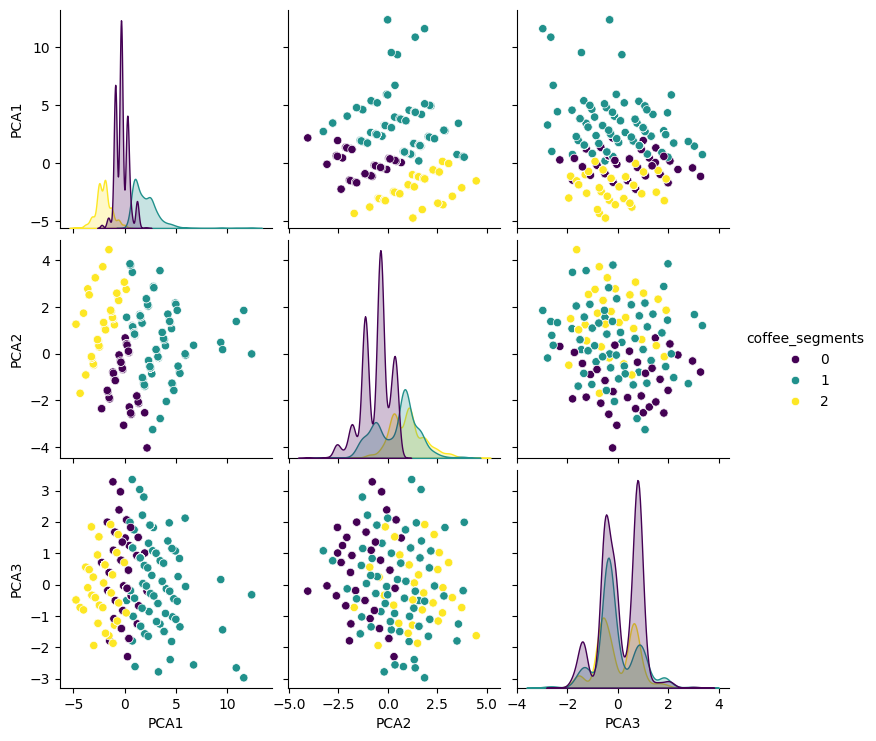

In [20]:
# Create a pair plot where scatter plots show relationships between feature components 
sns.pairplot(
    coffee_info_pca_predictions_df,
    hue='coffee_segments',  # color by clusters
    palette='viridis',      # colormap
    diag_kind='kde',         # use kernel density estimates on the diagonal
    height=2.5
)

plt.show()


In [21]:
# Save the models
joblib.dump(scaler, "models/scaler.joblib")
joblib.dump(pca, "models/pca_model.joblib")

# Load the KMeans model
loaded_scaler = joblib.load("models/scaler.joblib")
loaded_pca = joblib.load("models/pca_model.joblib")

## Encode target and include one-hot encoding into dataframe 

In [22]:
# labelEncode the slug and create a feature array 
from sklearn.preprocessing import LabelEncoder 

# Label encode the 'slug' column and create a new column 'target'
label_encoder = LabelEncoder()
coffee_data_df['target'] = label_encoder.fit_transform(coffee_data_df['rating'])

# Drop the original 'slug' column
coffee_data_df.drop('rating', axis=1, inplace=True)

In [23]:
coffee_data_df.head()

,slug,name,roaster,roast,country_of_origin,desc_1,desc_2,latitude,longitude,aroma,...,region_asia_pacific,region_south_america,type_espresso,type_organic,type_fair_trade,type_decaffeinated,type_pod_capsule,type_blend,type_estate,target
0,/review/ethiopia-deri-kochoha-2,Ethiopia Deri Kochoha,Flight Coffee Co.,Medium-Light,Ethiopia,"Bright, crisp, sweetly tart. Citrus medley, ca...",From the Deri Kochoha mill in the Hagere Marya...,6.767800,35.634371,9.0,...,0,0,0,0,0,0,0,0,0,15
1,/review/kenya-ruthaka-peaberry,Kenya Ruthaka Peaberry,Temple Coffee and Tea,Medium,Kenya,"Deeply sweet, richly savory. Dark chocolate, p...",Despite challenges ranging from contested gove...,1.441968,38.431398,9.0,...,0,0,0,0,0,0,0,0,0,17
2,/review/ethiopia-gora-kone-sidamo,Ethiopia Gora Kone Sidamo,Temple Coffee and Tea,Medium-Light,Ethiopia,"Fruitforward, richly chocolaty. Raspberry coul...",Southern Ethiopia coffees like this one are la...,6.767800,35.634371,9.0,...,0,0,0,0,0,0,0,0,0,15
3,/review/honduras-las-flores-parainema,Honduras Las Flores Parainema,Café Grumpy,Medium-Light,Honduras,"Spicetoned, complex, richly bittersweet. Black...",Produced by César Fernandez of El Cielito farm...,15.257243,-86.075514,9.0,...,0,0,0,0,0,0,0,0,0,16
4,/review/kivu-dr-congo,Kivu DR Congo,JBC Coffee Roasters,Medium-Light,"Congo, The Democratic Republic of the","Hightoned, balanced, crisply sweet. Apricot, t...",Produced entirely from trees of Bourbonrelated...,-2.981434,23.822264,9.0,...,0,0,0,1,1,0,0,0,0,16


In [24]:
# Make the target column the first column for ease access 
target_column = coffee_data_df['target']

# Drop the 'target' column from the DataFrame
coffee_data_df.drop('target', axis=1, inplace=True)

# Insert the 'target' column as the first column
coffee_data_df.insert(0, 'target', target_column)

In [25]:
# Create features and target
coffee_test = coffee_data_df[['roast']]

# # Remove null values  
# coffee_data_df = coffee_data_df.dropna()

In [26]:
# Assuming X is your DataFrame with columns 'aroma', 'body', 'flavor', 'acid', and 'aftertaste'
categorical_columns = ['roast']

# Use get_dummies to one-hot encode the categorical columns
coffee_test_encoded = pd.get_dummies(coffee_test[categorical_columns], columns=categorical_columns, dtype=int)

In [27]:
# Concatenate the one-hot encoded columns to the original DataFrame
coffee_test = pd.concat([coffee_test, coffee_test_encoded], axis=1)

In [28]:
coffee_test.head()

,roast,roast_Dark,roast_Light,roast_Medium,roast_Medium-Dark,roast_Medium-Light,roast_Very Dark
0,Medium-Light,0,0,0,0,1,0
1,Medium,0,0,1,0,0,0
2,Medium-Light,0,0,0,0,1,0
3,Medium-Light,0,0,0,0,1,0
4,Medium-Light,0,0,0,0,1,0


In [29]:
X_encoded = coffee_test.drop(columns=['roast'])

In [30]:
y = coffee_test['roast']

Generally a one-hot encoded dataframe would be able to give us user preference information. In this dataset, as it is being used as a recommender system and also there is no user input there was no y variable that we could conclude on to assess. Therefore the function test relied on the cosine_similarity function based on the user input.

In future projects, user input and ratings would be generally great information to look for.

# Testing function 

In [31]:
# Generate test data
coffee_test = pd.DataFrame({
    'aroma': np.random.randint(1, 11, 5),
    'body': np.random.randint(1, 11, 5),
    'flavor': np.random.randint(1, 11, 5),
    'acid': np.random.randint(1, 11, 5),
    'aftertaste': np.random.randint(1, 11, 5)
})

In [32]:
# Select a random coffee to test recommender system
test_rec = coffee_test.sample(1, replace=False).squeeze()

In [33]:
# Recommender function 
def coffee_recommender(aroma, flavor, acid, body, aftertaste, model, pca, data, top_n=5):
    # Transform user input using PCA
    input_data = pca.transform([[aroma, flavor, acid, body, aftertaste]])[0]
    input_array = input_data.reshape(1, -1)

    # Make predictions using the loaded KMeans model
    cluster_label = model.predict(input_array)[0]  # Fix input shape here

    # Assign the cluster label to a new column
    data['coffee_segments'] = model.predict(pca.transform(data[['aroma', 'flavor', 'acid', 'body', 'aftertaste']]))

    # Filter data for the predicted cluster
    recommended_coffees = data[data['coffee_segments'] == cluster_label]

    # Calculate cosine similarity for each row
    input_array = input_data.reshape(1, -1)
    recommended_coffees['similarity_factor'] = recommended_coffees.apply(lambda row: cosine_similarity(input_array, row[['aroma', 'flavor', 'acid', 'body', 'aftertaste']].values.reshape(1, -1))[0][0], axis=1)

    # Get the indices of the top N similar items
    top_indices = recommended_coffees['similarity_factor'].nlargest(top_n).index.tolist()

    return recommended_coffees.loc[top_indices]


In [34]:
# # Function to return the recommended coffee 
# def recommend_coffees(test_rec, coffee_df, model, pca):
#     aroma, flavor, acid, body, aftertaste = test_rec['aroma'], test_rec['flavor'], test_rec['acid'], test_rec['body'], test_rec['aftertaste']
    
#     recommended_coffees = coffee_recommender(aroma, flavor, acid, body, aftertaste, model, pca, coffee_df)

#     # Print only the top 5 recommendations
#     for i, (_, row) in enumerate(recommended_coffees[['name', 'roaster', 'roast', 'country_of_origin', 'desc_1', 'desc_2']].iterrows(), 1):
#         if i > 5:
#             break
#         print(f"Recommendation #{i}")
#         print(f"Name: {row['name']}")
#         print(f"Roaster: {row['roaster']}")
#         print(f"Roast: {row['roast']}")
#         print(f"Country of Origin: {row['country_of_origin']}")
#         print(f"Description 1: {row['desc_1']}")
#         print(f"Description 2: {row['desc_2']}")
#         print("\n")

# # Call the function with the test data
# for index, row in coffee_test.iterrows():
#     print(f"\nUser Input: {row.to_dict()}")
#     recommend_coffees(row, coffee_data_df, loaded_scaler, loaded_pca)

#Attempt Vectorisation 

In [35]:
from sklearn.feature_extraction.text import CountVectorizer

# Fill missing values in desc_1 column with an empty string
coffee_data_df['desc_1'] = coffee_data_df['desc_1'].fillna('')

# Convert desc_1 column to string type
desc_1_text = coffee_data_df['desc_1'].astype(str)

# Create a matrix for desc_1
X_desc_1 = CountVectorizer().fit_transform(desc_1_text).toarray()

print("Matrix for desc_1:")
print(X_desc_1)


Matrix for desc_1:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [36]:
def calculate_cosine_similarity(matrix, row_idx1, row_idx2):
    cos_sim = cosine_similarity(matrix[row_idx1, :].reshape(1, -1), matrix[row_idx2, :].reshape(1, -1))[0, 0]
    return cos_sim

# Iterate through rows using iterrows
for idx1, row1 in coffee_data_df.iterrows():
    for idx2, row2 in coffee_data_df.iterrows():
        if idx1 < idx2:  # Avoid comparing the same document and duplicates
            cos_sim = calculate_cosine_similarity(X_desc_1, idx1, idx2)
            print(f'Cosine Similarity between coffee_id {idx1 + 1} and coffee_id {idx2 + 1}: {cos_sim}')
            


Cosine Similarity between coffee_id 1 and coffee_id 2: 0.40155785387702214
Cosine Similarity between coffee_id 1 and coffee_id 3: 0.3784378163042982
Cosine Similarity between coffee_id 1 and coffee_id 4: 0.39291979450300124
Cosine Similarity between coffee_id 1 and coffee_id 5: 0.42246305606312096
Cosine Similarity between coffee_id 1 and coffee_id 6: 0.5564148840746572
Cosine Similarity between coffee_id 1 and coffee_id 7: 0.4188539082916955
Cosine Similarity between coffee_id 1 and coffee_id 8: 0.5026246899500346
Cosine Similarity between coffee_id 1 and coffee_id 9: 0.40816499998243644
Cosine Similarity between coffee_id 1 and coffee_id 10: 0.36527478620450904
Cosine Similarity between coffee_id 1 and coffee_id 11: 0.30526018266379085
Cosine Similarity between coffee_id 1 and coffee_id 12: 0.35942537872389224
Cosine Similarity between coffee_id 1 and coffee_id 13: 0.3250056229832959
Cosine Similarity between coffee_id 1 and coffee_id 14: 0.4101124476038661
Cosine Similarity between 

Cosine Similarity between coffee_id 1 and coffee_id 540: 0.42863977582145585
Cosine Similarity between coffee_id 1 and coffee_id 541: 0.39735970711951313
Cosine Similarity between coffee_id 1 and coffee_id 542: 0.32662766723200665
Cosine Similarity between coffee_id 1 and coffee_id 543: 0.4891159880445185
Cosine Similarity between coffee_id 1 and coffee_id 544: 0.36708551190375976
Cosine Similarity between coffee_id 1 and coffee_id 545: 0.4030644450801477
Cosine Similarity between coffee_id 1 and coffee_id 546: 0.2869820106974262
Cosine Similarity between coffee_id 1 and coffee_id 547: 0.4193296085112077
Cosine Similarity between coffee_id 1 and coffee_id 548: 0.4764352561538061
Cosine Similarity between coffee_id 1 and coffee_id 549: 0.38939577897263383
Cosine Similarity between coffee_id 1 and coffee_id 550: 0.46192127684579
Cosine Similarity between coffee_id 1 and coffee_id 551: 0.29319773580418684
Cosine Similarity between coffee_id 1 and coffee_id 552: 0.42714885034479166
Cosine 

KeyboardInterrupt: 

In [ ]:
def find_top_similar_items(cosine_similarity_matrix):
    # Iterate through rows
    for i in range(cosine_similarity_matrix.shape[0]):
        # Sort cosine similarity values in descending order and get the top 5 indices
        top5_indices = cosine_similarity_matrix[i].argsort()[:-6:-1]

        # Print the results
        print(f'Top 5 most similar items to Document {i + 1}:')
        for j in top5_indices:
            print(f'\tDocument {j + 1} - Similarity: {cosine_similarity_matrix[i, j]}')
            
# Find top 5 most similar items for each document
find_top_similar_items(cos_sim) 

IndexError: tuple index out of range